This example shows how to perform GP regression, but using **variational inference** rather than exact inference. There are a few cases where variational inference may be prefereable:

1) If you have lots of data, and want to perform **stochastic optimization**

2) If you have a model where you want to use other variational distributions

KISS-GP with SVI was introduced in:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Create a training set
# We're going to learn a sine function
train_x = torch.linspace(0, 1, 1000)
train_y = torch.sin(train_x * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2

## Performing SGD - the dataloader

Because we want to do stochastic optimization, we have to put the dataset in a pytorch **DataLoader**.
This creates easy minibatches of the data

In [3]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## The model

This is pretty similar to a normal regression model, except now we're using a `gpytorch.models.GridInducingVariationalGP` instead of a `gpytorch.models.ExactGP`.

Any of the variational models would work. We're using the `GridInducingVariationalGP` because we have many data points, but only 1 dimensional data.

Similar to exact regression, we use a `GaussianLikelihood`.

In [4]:
from gpytorch.means import ConstantMean
from gpytorch.kernels import RBFKernel
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.random_variables import GaussianRandomVariable

class GPRegressionModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        super(GPRegressionModel, self).__init__(grid_size=20, grid_bounds=[(-0.05, 1.05)])
        self.mean_module = ConstantMean(prior=SmoothedBoxPrior(-1e-5, 1e-5))
        self.covar_module = RBFKernel(
            log_lengthscale_prior=SmoothedBoxPrior(math.exp(-3), math.exp(6), sigma=0.1, log_transform=True)
        )
        self.register_parameter(
            name="log_outputscale",
            parameter=torch.nn.Parameter(torch.Tensor([0])),
            prior=SmoothedBoxPrior(math.exp(-5), math.exp(1), sigma=0.1, log_transform=True),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x) * self.log_outputscale.exp()
        return GaussianRandomVariable(mean_x, covar_x)
    
model = GPRegressionModel().cuda()
likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()

## The training loop

This training loop will use **stochastic optimization** rather than batch optimization

In [5]:
model.train()
likelihood.train()

# We'll do 40 iterations of optimization
n_iter = 40

# We use SGD here, rather than Adam
# Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

# We use a Learning rate scheduler from PyTorch to lower the learning rate during optimization
# We're going to drop the learning rate by 1/10 after 3/4 of training
# This helps the model converge to a minimum
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.75 * n_iter], gamma=0.1)

# Our loss object
# We're using the VariationalMarginalLogLikelihood object
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, n_data=train_y.size(0))

# The training loop
def train():
    for i in range(n_iter):
        scheduler.step()
        
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            x_batch = torch.autograd.Variable(x_batch.float().cuda())
            y_batch = torch.autograd.Variable(y_batch.float().cuda())
            optimizer.zero_grad()
            
            # We're going to use two context managers here
            
            # The use_toeplitz flag makes learning faster on the GPU
            # See the DKL-MNIST notebook for an explanation
            
            # The diagonal_correction flag improves the approximations we're making for variational inference
            # It makes running time a bit slower, but improves the optimization and predictions
            with gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
                output = model(x_batch)
                loss = -mll(output, y_batch)
                print('Iter %d/%d - Loss: %.3f (%.3f)' % (i + 1, n_iter, loss.data[0], optimizer.param_groups[0]['lr']))
            
            # The actual optimization step
            loss.backward()
            optimizer.step()
            
%time train()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter 1/40 - Loss: 11.036 (0.100)
Iter 1/40 - Loss: 8.227 (0.100)
Iter 1/40 - Loss: 6.163 (0.100)
Iter 1/40 - Loss: 4.766 (0.100)
Iter 1/40 - Loss: 3.743 (0.100)
Iter 1/40 - Loss: 2.963 (0.100)
Iter 1/40 - Loss: 2.473 (0.100)
Iter 1/40 - Loss: 2.279 (0.100)
Iter 1/40 - Loss: 1.975 (0.100)
Iter 1/40 - Loss: 1.926 (0.100)
Iter 1/40 - Loss: 1.867 (0.100)
Iter 1/40 - Loss: 1.813 (0.100)
Iter 1/40 - Loss: 1.842 (0.100)
Iter 1/40 - Loss: 1.784 (0.100)
Iter 1/40 - Loss: 1.765 (0.100)
Iter 1/40 - Loss: 1.739 (0.100)
Iter 2/40 - Loss: 1.669 (0.100)
Iter 2/40 - Loss: 1.606 (0.100)
Iter 2/40 - Loss: 1.560 (0.100)
Iter 2/40 - Loss: 1.537 (0.100)
Iter 2/40 - Loss: 1.495 (0.100)
Iter 2/40 - Loss: 1.411 (0.100)
Iter 2/40 - Loss: 1.401 (0.100)
Iter 2/40 - Loss: 1.342 (0.100)
Iter 2/40 - Loss: 1.273 (0.100)
Iter 2/40 - Loss: 1.237 (0.100)
Iter 2/40 - Loss: 1.161 (0.100)
Iter 2/40 - Loss: 1.123 (0.100)
Iter 2/40 - Loss: 1.069 (0.100)
Iter 2/40 - Loss: 1.004 (0.100)
Iter 2/40 - Loss: 0.944 (0.100)
Iter 2/

Iter 16/40 - Loss: 0.033 (0.100)
Iter 16/40 - Loss: -0.033 (0.100)
Iter 16/40 - Loss: -0.053 (0.100)
Iter 16/40 - Loss: 0.000 (0.100)
Iter 17/40 - Loss: 0.021 (0.100)
Iter 17/40 - Loss: -0.277 (0.100)
Iter 17/40 - Loss: -0.177 (0.100)
Iter 17/40 - Loss: -0.074 (0.100)
Iter 17/40 - Loss: 0.091 (0.100)
Iter 17/40 - Loss: -0.037 (0.100)
Iter 17/40 - Loss: -0.160 (0.100)
Iter 17/40 - Loss: -0.051 (0.100)
Iter 17/40 - Loss: -0.248 (0.100)
Iter 17/40 - Loss: -0.012 (0.100)
Iter 17/40 - Loss: -0.018 (0.100)
Iter 17/40 - Loss: -0.052 (0.100)
Iter 17/40 - Loss: 0.092 (0.100)
Iter 17/40 - Loss: -0.033 (0.100)
Iter 17/40 - Loss: -0.021 (0.100)
Iter 17/40 - Loss: 0.168 (0.100)
Iter 18/40 - Loss: -0.082 (0.100)
Iter 18/40 - Loss: 0.086 (0.100)
Iter 18/40 - Loss: -0.046 (0.100)
Iter 18/40 - Loss: -0.014 (0.100)
Iter 18/40 - Loss: -0.081 (0.100)
Iter 18/40 - Loss: -0.052 (0.100)
Iter 18/40 - Loss: 0.090 (0.100)
Iter 18/40 - Loss: 0.035 (0.100)
Iter 18/40 - Loss: -0.158 (0.100)
Iter 18/40 - Loss: -0.1

Iter 32/40 - Loss: -0.070 (0.010)
Iter 32/40 - Loss: -0.106 (0.010)
Iter 32/40 - Loss: -0.159 (0.010)
Iter 32/40 - Loss: -0.092 (0.010)
Iter 32/40 - Loss: -0.256 (0.010)
Iter 32/40 - Loss: -0.141 (0.010)
Iter 32/40 - Loss: -0.154 (0.010)
Iter 32/40 - Loss: -0.068 (0.010)
Iter 32/40 - Loss: -0.110 (0.010)
Iter 32/40 - Loss: -0.013 (0.010)
Iter 32/40 - Loss: -0.060 (0.010)
Iter 32/40 - Loss: -0.169 (0.010)
Iter 32/40 - Loss: -0.266 (0.010)
Iter 32/40 - Loss: -0.225 (0.010)
Iter 33/40 - Loss: -0.225 (0.010)
Iter 33/40 - Loss: -0.159 (0.010)
Iter 33/40 - Loss: -0.088 (0.010)
Iter 33/40 - Loss: -0.047 (0.010)
Iter 33/40 - Loss: -0.190 (0.010)
Iter 33/40 - Loss: -0.139 (0.010)
Iter 33/40 - Loss: -0.176 (0.010)
Iter 33/40 - Loss: -0.059 (0.010)
Iter 33/40 - Loss: -0.151 (0.010)
Iter 33/40 - Loss: -0.162 (0.010)
Iter 33/40 - Loss: -0.149 (0.010)
Iter 33/40 - Loss: -0.121 (0.010)
Iter 33/40 - Loss: -0.042 (0.010)
Iter 33/40 - Loss: -0.225 (0.010)
Iter 33/40 - Loss: -0.105 (0.010)
Iter 33/40 - L

## Testing the model

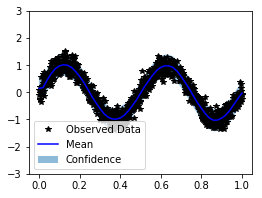

In [6]:
model.eval()
likelihood.eval()

test_x = torch.autograd.Variable(torch.linspace(0, 1, 51)).cuda()
with gpytorch.settings.max_cg_iterations(2000), gpytorch.settings.use_toeplitz(False), gpytorch.beta_features.diagonal_correction():
    observed_pred = likelihood(model(test_x))

lower, upper = observed_pred.confidence_region()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
ax.plot(test_x.data.cpu().numpy(), observed_pred.mean().data.cpu().numpy(), 'b')
ax.fill_between(test_x.data.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha=0.5)
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])